# Tutorial 3: Analysis

<a id='trajanalysis'></a>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

This notebook is adapted from materials developed for the [2018 Workshop/Hackathon](https://github.com/MDAnalysis/WorkshopHackathon2018) and the [MDAnalysis User Guide](https://userguide.mdanalysis.org/stable/examples/analysis/custom_trajectory_analysis.html#Creating-an-analysis-from-a-function).

### Learning outcomes 

- Understand how analysis methods that act on `Atomgroups`, such as root mean square deviation (RMSD), work
- Creating your own analysis class with MDAnalysis

#### Additional resources

 - During the workshop, feel free to ask questions at any time
 - For more on how to use MDAnalysis, see the [User Guide](https://userguide.mdanalysis.org/stable/index.html) and [documentation](https://docs.mdanalysis.org/stable/index.html)
 - Ask questions on the [GitHub Discussions forum](https://github.com/MDAnalysis/mdanalysis/discussions) or on [Discord](https://discord.gg/fXTSfDJyxE)
 - Report bugs on [GitHub](https://github.com/MDAnalysis/mdanalysis/issues?)


# Google Colab package installs

This installs the necessary packages for Google Colab. Please only run these if you are using Colab.

In [ ]:
# NBVAL_SKIP
!pip install condacolab
import condacolab
condacolab.install()

In [ ]:
# NBVAL_SKIP
import condacolab
condacolab.check()
!mamba install -c conda-forge mdanalysis mdanalysistests mdanalysisdata nglview rdkit

In [ ]:
# NBVAL_SKIP
# enable third party jupyter widgets
from google.colab import output
output.enable_custom_widget_manager()

### **Jupyter cheat sheet**
- to run the currently highlighted cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- to get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;

<div class="alert alert-warning"><b> REMEMBER: variables persist between cells</b> 
    
Be aware that it is the order of execution of cells that is important in a Jupyter notebook, not the <em>order</em> in which they appear. Python will remember <em>all</em> the code that was run previously, including any variables you have defined, irrespective of the order in the notebook. Therefore if you define variables lower down the notebook and then (re)run cells further up, those defined further down will still be present. </div> 

In [1]:
import warnings
warnings.filterwarnings("ignore") 

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nglview as nv
import MDAnalysis as mda
from MDAnalysis.lib import distances 
from MDAnalysis.analysis import rdf
import MDAnalysisData as data

/Users/ugmhackathon/mambaforge/envs/mda_workshop/lib/python3.11/site-packages/MDAnalysisData/base.py:34: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_string


## 1. Root mean square deviation (RMSD)

Here we calculate the RMSD of domains in adenylate kinase (AdK), a phosophotransferase enzyme, as it transitions from an open to closed structure.

In [3]:
from MDAnalysis.tests.datafiles import PSF, DCD, CRD
from MDAnalysis.analysis import rms

import pandas as pd

The trajectory DCD samples a transition from a closed to an open conformation. AdK has three domains:

- CORE
- LID: an ATP-binding domain
- NMP: an AMP-binding domain

The LID and NMP domains move around the stable CORE as the enzyme transitions between the opened and closed conformations. One way to quantify this movement is by calculating the root mean square deviation (RMSD) of atomic positions.

In [4]:
u = mda.Universe(PSF, DCD)  # closed AdK (PDB ID: 1AKE)
ref = mda.Universe(PSF, CRD)  # open AdK (PDB ID: 4AKE)

/Users/ugmhackathon/mambaforge/envs/mda_workshop/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


### Background: RMSD

The root mean square deviation (RMSD) of particle coordinates is one measure of distance, or dissimilarity, between molecular conformations. Each structure should have matching elementwise atoms $i$ in the same order, as the distance between them is calculated and summed for the final result. It is calculated between coordinate arrays $\mathbf{x}$ and $\mathbf{x}^{\text{ref}}$ according to the equation below:

$$ \text{RMSD}(\mathbf{x}, \mathbf{x}^{\text{ref}}) = \sqrt{\frac{1}{n} \sum_{i=1}^{n}{|\mathbf{x}_i-\mathbf{x}_i^{\text{ref}}|^2}} $$

As molecules can move around, the structure $\mathbf{x}$ is usually translated by a vector $\mathbf{t}$ and rotated by a matrix $\mathsf{R}$ to align with the reference $\mathbf{x}^{\text{ref}}$ such that the RMSD is minimised. The RMSD after this optimal superposition can be expressed as follows:

$$ \text{RMSD}(\mathbf{x}, \mathbf{x}^{\text{ref}}) = \min_{\mathsf{R}, \mathbf{t}} %
  \sqrt{\frac{1}{N} \sum_{i=1}^{N} \left[ %
      (\mathsf{R}\cdot\mathbf{x}_{i}(t) + \mathbf{t}) - \mathbf{x}_{i}^{\text{ref}} \right]^{2}}$$

The RMSD between one reference state and a trajectory of structures is often calculated as a way to measure the dissimilarity of the trajectory conformational ensemble to the reference. This reference is frequently the first frame of the trajectory (the default in MDAnalysis), in which case it can provide insight into the overall movement from the initial starting point. W

Typically not all coordinates in a structures are included in an RMSD analysis. With proteins, the fluctuation of the residue side-chains is not representative of overall conformational change. Therefore when RMSD analyses are performed to investigate large-scale movements in proteins, the atoms are usually restricted only to the backbone atoms (forming the amide-bond chain) or the alpha-carbon atoms. 

MDAnalysis provides functions and classes to calculate the RMSD between coordinate arrays, and `Universes` or `AtomGroups`.  The contribution of each particle $i$ to the final RMSD value can also be weighted.


### RMSD between two sets of coordinates

The MDAnalysis.analysis.rms.rmsd function returns the root mean square deviation (in Angstrom) between two sets of coordinates. Here, we calculate the RMSD between the backbone atoms of the open and closed conformations of AdK. 

In [5]:
# RMSD Function Implementing the Above Equation
backbone_ag = u.select_atoms('backbone')
ref_ag = ref.select_atoms('backbone')
rms.rmsd(backbone_ag.positions,  # coordinates to align
         ref_ag.positions,  # reference coordinates
         center=True,  # subtract the center of geometry
         superposition=True)  # superimpose coordinates

6.823686867261616

<div class="alert alert-success"> <b>Exercise 1</b> 

Write your own trajectory iteration and get the RMSD of backbone atoms relative to the reference over time.
</div>

In [6]:
# Exercise 1

#### Exercise 1 solution

In [7]:
# Exercise 1 solution

rmsd_results = np.zeros(u.trajectory.n_frames)

backbone_ag = u.select_atoms('backbone')
ref_ag = ref.select_atoms('backbone')

for i, ts in enumerate(u.trajectory):
    rmsd_results[i] = rms.rmsd(backbone_ag.positions,  # coordinates to align
                               ref_ag.positions,  # reference coordinates
                               center=True,  # subtract the center of geometry
                               superposition=True)  # superimpose coordinates

print(rmsd_results)

[6.82368687 6.71926991 6.61572955 6.52929675 6.43862693 6.35782819
 6.28123668 6.20690655 6.12838641 6.0299184  5.93945175 5.85839369
 5.77592029 5.69462238 5.61155126 5.5281683  5.44614643 5.36947787
 5.27785367 5.19365894 5.11679071 5.03967991 4.96901347 4.89805889
 4.82726983 4.75065867 4.67096042 4.57934297 4.49845659 4.42320576
 4.34275131 4.2747248  4.20598916 4.14576263 4.0839381  4.02082565
 3.9262493  3.86205122 3.76515705 3.69237759 3.62036106 3.53185352
 3.43816122 3.36155692 3.28617794 3.19980089 3.12496826 3.04046049
 2.95195257 2.87687721 2.80769534 2.73973414 2.66422176 2.5829632
 2.51731204 2.44606579 2.36723069 2.27772649 2.21077804 2.14044593
 2.06508845 2.01232012 1.9412279  1.88191098 1.81545519 1.74576299
 1.67966118 1.61349704 1.5516766  1.47917424 1.42116392 1.36527209
 1.3173664  1.25410874 1.2092104  1.16588536 1.12888446 1.08336024
 1.05449296 1.02442912 0.98328031 0.9495711  0.91225704 0.880558
 0.84514044 0.81348164 0.77143986 0.7418361  0.70903679 0.6785563

### RMSD analysis class

It is more efficient to use the `MDAnalysis.analysis.rms.RMSD` class to calculate the RMSD of an entire trajectory to a single reference point, than to use the the `MDAnalysis.analysis.rms.rmsd` function.

The `rms.RMSD` class first performs a rotational and translational alignment of the target trajectory to the reference universe at `ref_frame`, using the atoms in select to determine the transformation. The RMSD of the select selection is calculated.

<div class="alert alert-success"> <b>Exercise 2</b> 

Now use `RMSD` class to achieve the same goal.

Hint: refer to https://docs.mdanalysis.org/stable/documentation_pages/analysis/rms.html#MDAnalysis.analysis.rms.RMSD or use the magic command `rms.RMSD?`
</div>

In [25]:
# Exercise 2

#### Exercise 2 solution

In [9]:
# Exercise 2 solution

backbone_ag = u.select_atoms('backbone')
ref_ag = ref.select_atoms('backbone')
R = rms.RMSD(atomgroup=backbone_ag,
             reference=ref_ag)
R.run()

R_results = R.results.rmsd.T[2] # the third column is the rmsd value

# Alternative solution

R_2 = rms.RMSD(atomgroup=u,
             reference=ref,
             select='backbone')
R_2.run()

R_2_results = R_2.results.rmsd.T[2] # the third column is the rmsd value

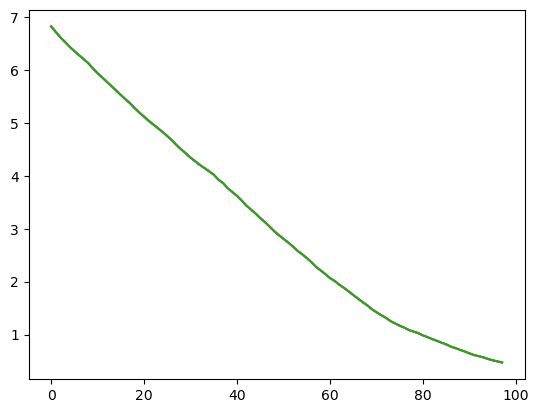

In [10]:
plt.plot(R_results)
plt.plot(R_2_results)
plt.plot(rmsd_results)

### RMSD with multiple selections

<div class="alert alert-success">
  <b>Exercise 3</b> 

  I now want to see the relative movement of each important domain (CORE, LID, NMP defined below) based on the RMSD value relative to its **starting position**. What could I do?

  Hint 1: Align the system based on all the backbone atoms.

  Hint 2: Use `groupselections`.
</div>

In [11]:
CORE = 'backbone and (resid 1-29 or resid 60-121 or resid 160-214)'
LID = 'backbone and resid 122-159'
NMP = 'backbone and resid 30-59'

In [12]:
# Exercise 3

#### Exercise 3 solution

In [13]:
R = rms.RMSD(u,  # universe to align
             u,  # reference universe or atomgroup
             select='backbone',  # group to superimpose and calculate RMSD
             groupselections=[CORE, LID, NMP],  # groups for RMSD
             ref_frame=0)  # frame index of the reference
R.run()

### Plotting the data

We can easily plot this data using the common data analysis package `pandas`. We turn the `R.rmsd` array into a `DataFrame` and label each column below.


In [14]:
df = pd.DataFrame(R.results.rmsd,
                  columns=['Frame', 'Time (ns)',
                           'Backbone', 'CORE',
                           'LID', 'NMP'])

df

,Frame,Time (ns),Backbone,CORE,LID,NMP
0,0.0,1.000000,5.834344e-07,3.921486e-08,1.197000e-07,6.276497e-08
1,1.0,2.000000,4.636592e-01,4.550181e-01,4.871915e-01,4.745572e-01
2,2.0,3.000000,6.419340e-01,5.754418e-01,7.940994e-01,7.270191e-01
3,3.0,4.000000,7.743983e-01,6.739184e-01,1.010261e+00,8.795031e-01
4,4.0,5.000000,8.588600e-01,7.318859e-01,1.168397e+00,9.612989e-01
...,...,...,...,...,...,...
93,93.0,93.999992,6.817898e+00,3.504430e+00,1.143376e+01,1.029266e+01
94,94.0,94.999992,6.804211e+00,3.480681e+00,1.141134e+01,1.029879e+01
95,95.0,95.999992,6.807987e+00,3.508946e+00,1.137593e+01,1.031958e+01
96,96.0,96.999991,6.821205e+00,3.498081e+00,1.139156e+01,1.037768e+01


Text(0, 0.5, 'RMSD ($\\AA$)')

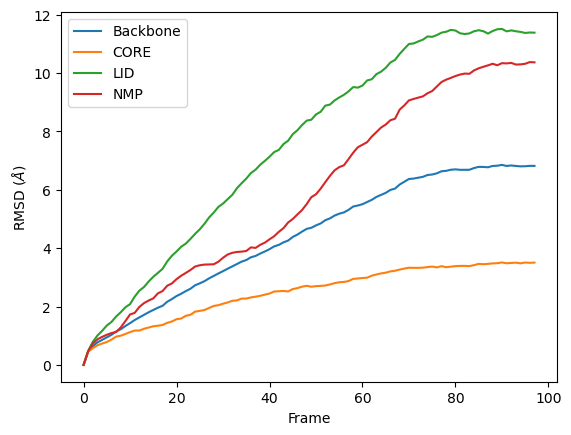

In [15]:
ax = df.plot(x='Frame', y=['Backbone', 'CORE', 'LID', 'NMP'],
             kind='line')
ax.set_ylabel(r'RMSD ($\AA$)')

<div class="alert alert-info"> <b> Reminder: </b> 


Some analysis tools (`radius_of_gyration`, `center_of_mass` etc) act on `positions` (which are properties of a single `timestep`). To calculate the property of interest for each frame, we need to iterate over the whole trajectory. 

Others (`RDF`, `rms.RMSD` etc) act on `AtomGroups`, and can iterate over the whole trajectory for us.

</div>

## 2. Writing your own analysis class

We will now demonstrate how to write your own analysis class.

Note: there are methods e.g. `AnalysisFromFunction`, `analysis_class` that can convert simple function into a functional analysis class.

**If you implement your own analysis method, please consider [contributing it to the MDAnalysis codebase!](https://www.mdanalysis.org/UserGuide/contributing.html) or create an MDAKit!**


In [16]:
from MDAnalysis.tests.datafiles import PSF, DCD
from MDAnalysis.analysis.base import AnalysisBase
import numpy as np
import matplotlib.pyplot as plt

### Radius of gyration

Let's start off by defining a standalone analysis function.

The radius of gyration of a structure measures how compact it is. In [GROMACS](http://manual.gromacs.org/documentation/2019-rc1/reference-manual/analysis/radius-of-gyration.html), it is calculated as follows: 

$$ R_g = \sqrt{\frac{\sum_i m_i \mathbf{r}_i^2}{\sum_i m_i}}$$

where $m_i$ is the mass of atom $i$ and $\mathbf{r}_i$ is the position of atom $i$, relative to the center-of-mass of the selection.

The radius of gyration around each axis can also be determined separately. For example, the radius of gyration around the x-axis:

$$ R_{i, x} = \sqrt{\frac{\sum_i m_i [r_{i, y}^2 + r_{i, z}^2]}{\sum_i m_i}}$$

Below, we define a function that takes an AtomGroup and calculates the radii of gyration. We could write this function to only need the AtomGroup. However, we also add in a `masses` argument and a `total_mass` keyword to avoid recomputing the mass and total mass for each frame.

In [17]:
def radgyr(atomgroup, masses, total_mass=None):
    # coordinates change for each frame
    coordinates = atomgroup.positions
    center_of_mass = atomgroup.center_of_mass()
    
    # get squared distance from center
    ri_sq = (coordinates-center_of_mass)**2
    # sum the unweighted positions
    sq = np.sum(ri_sq, axis=1)
    sq_x = np.sum(ri_sq[:,[1,2]], axis=1) # sum over y and z
    sq_y = np.sum(ri_sq[:,[0,2]], axis=1) # sum over x and z
    sq_z = np.sum(ri_sq[:,[0,1]], axis=1) # sum over x and y
    
    # make into array
    sq_rs = np.array([sq, sq_x, sq_y, sq_z])
    
    # weight positions
    rog_sq = np.sum(masses*sq_rs, axis=1)/total_mass
    # square root and return
    return np.sqrt(rog_sq)

I want to calculate the radius of gyration of my protein overall and along three dimensions

In [18]:
u = mda.Universe(PSF, DCD)
protein = u.select_atoms('protein')
protein_masses = protein.masses
total_mass = np.sum(protein_masses)

/Users/ugmhackathon/mambaforge/envs/mda_workshop/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [19]:
radgyr_results = np.zeros([u.trajectory.n_frames, 4])

for i, ts in enumerate(u.trajectory):
    radgyr_results[i] = radgyr(atomgroup=protein,
                          masses=protein_masses,
                          total_mass=total_mass)

Text(0.5, 0, 'Frame')

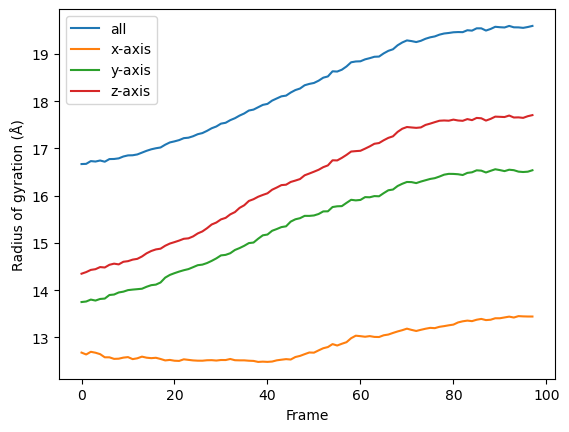

In [20]:
labels = ['all', 'x-axis', 'y-axis', 'z-axis']
for col, label in zip(radgyr_results.T, labels):
    plt.plot(col, label=label)
plt.legend()
plt.ylabel('Radius of gyration (Å)')
plt.xlabel('Frame')

In [21]:
view = nv.show_mdanalysis(protein)
view.add_representation('axes')

In [22]:
view

NGLWidget(max_frame=97)

<div class="alert alert-success">
  <b>Exercise 4</b> 

  I want to create a `RadiusOfGyration` class that inherits from `AnalysisBase` to add this functionality to my MD toolbox. Recall the three methods that I need to implement:
  - `__init__`
  - `_prepare`
  - `_single_frame`

  Here’s a reference for how the `run` method in `AnalysisBase` works:
  ```python
  class AnalysisBase:
     ...
     def run(self, start, stop, step, ...):
          self._setup_frames()
          self._prepare()
          for ts in self.trajectory:
              self._single_frame()
          self._conclude()
          return self
  ```

  Hint 1: Use `self._frame_index` to retrieve the current frame index.

  Hint 2: Use the `radgyr` function in `_single_frame`.
</div>

In [ ]:
# Exercise 4
class RadiusOfGyration(AnalysisBase):
    def __init__(self, atomgroup, **kwargs):
        # set parameters
        ...
        super().__init__(atomgroup.universe.trajectory,
                         **kwargs)

    def _prepare(self):
        # called before iteration on the trajectory has begun.
        # initialize results
        ...

    def _single_frame(self):
        # called after the trajectory is moved onto each new frame.
        ...

In [ ]:
rog = RadiusOfGyration(atomgroup=protein)
rog.run()

rog_results = rog.results.radgyr

labels = ['all', 'x-axis', 'y-axis', 'z-axis']
for col, label in zip(rog_results.T, labels):
    plt.plot(col, label=label)
plt.legend()
plt.ylabel('Radius of gyration (Å)')
plt.xlabel('Frame')

#### Exercise 4 solution

In [23]:
# Exercise 4 solution
class RadiusOfGyration(AnalysisBase):
    def __init__(self, atomgroup, **kwargs):
        self.atomgroup = atomgroup
        self.atom_masses = atomgroup.masses
        self.total_mass = np.sum(atomgroup.masses)
        super().__init__(atomgroup.universe.trajectory,
                         **kwargs)

    def _prepare(self):
        # called before iteration on the trajectory has begun.
        # initialize results
        self.results.radgyr = np.zeros([u.trajectory.n_frames, 4])

    def _single_frame(self):
        # called after the trajectory is moved onto each new frame.
        self.results.radgyr[self._frame_index] = radgyr(self.atomgroup, self.atom_masses, self.total_mass)

Text(0.5, 0, 'Frame')

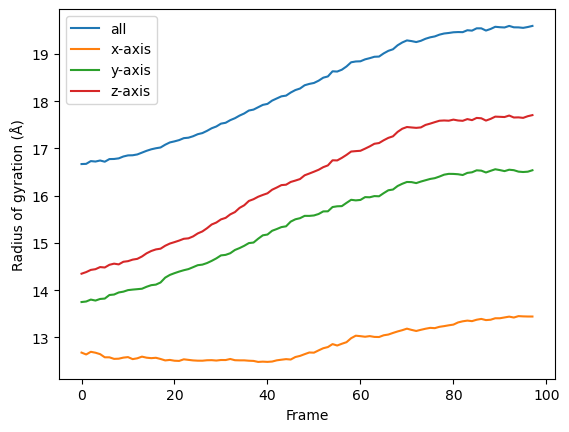

In [24]:
rog = RadiusOfGyration(atomgroup=protein)
rog.run()

rog_results = rog.results.radgyr

labels = ['all', 'x-axis', 'y-axis', 'z-axis']
for col, label in zip(rog_results.T, labels):
    plt.plot(col, label=label)
plt.legend()
plt.ylabel('Radius of gyration (Å)')
plt.xlabel('Frame')

## Contributing to MDAnalysis

If you think that you will want to reuse your new analysis, or that others might find it helpful, please consider [contributing it to the MDAnalysis codebase.](https://www.mdanalysis.org/UserGuide/contributing.html) Making your code open-source can have many benefits; others may notice an unexpected bug or suggest ways to optimise your code. If you write your analysis for a specific publication, please let us know; we will ask those who use your code to cite your reference in published work.